In [30]:
import pandas as pd
import numpy as np
import os
import sys
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from tqdm import tqdm

import xml.etree.ElementTree as ET
from tifffile import imread
from tifffile import TiffFile

from skimage.color import rgb2gray
from skimage.color import label2rgb
from skimage.transform import rescale
from skimage.exposure import rescale_intensity
from skimage.measure import regionprops
from skimage.measure import regionprops_table
from skimage.segmentation import mark_boundaries

# stardist
from csbdeep.utils import normalize
from stardist.models import StarDist2D

# Load metadata

In [2]:
_OME_NS = {"ome": "http://www.openmicroscopy.org/Schemas/OME/2016-06"}

def load_ome_physical_info(fpath):
    """Return (info: dict, pixels_to_physical: callable) and print a summary."""
    with TiffFile(fpath) as tif:
        ome_xml = tif.ome_metadata
        dtype = tif.pages[0].dtype if tif.pages else None

    root = ET.fromstring(ome_xml)

    # Core Pixels block
    px = root.find(".//ome:Image/ome:Pixels", _OME_NS)
    sizeX = int(px.get("SizeX"))
    sizeY = int(px.get("SizeY"))
    sizeZ = int(px.get("SizeZ", 1))
    sizeC = int(px.get("SizeC", 1))
    sizeT = int(px.get("SizeT", 1))
    dim_order = px.get("DimensionOrder")
    dtype_xml = px.get("Type")

    # Physical sizes (+ units if present; OME often omits => assume µm)
    sx = float(px.get("PhysicalSizeX"))
    sy = float(px.get("PhysicalSizeY"))
    sx_unit = px.get("PhysicalSizeXUnit") or "µm"
    sy_unit = px.get("PhysicalSizeYUnit") or "µm"

    # Optional global origin: Plate origin + WellSample position (if present)
    plate = root.find(".//ome:Plate", _OME_NS)
    well_sample = root.find(".//ome:Well/ome:WellSample", _OME_NS)

    well_origin_x = float(plate.get("WellOriginX")) if plate is not None and plate.get("WellOriginX") else 0.0
    well_origin_y = float(plate.get("WellOriginY")) if plate is not None and plate.get("WellOriginY") else 0.0
    pos_x = float(well_sample.get("PositionX")) if well_sample is not None and well_sample.get("PositionX") else 0.0
    pos_y = float(well_sample.get("PositionY")) if well_sample is not None and well_sample.get("PositionY") else 0.0

    origin_x = well_origin_x + pos_x
    origin_y = well_origin_y + pos_y
    origin_unit = "µm"  # OME positions default to µm unless specified otherwise

    # Channels (names)
    ch_names = [
        ch.get("Name") or f"Channel-{i}"
        for i, ch in enumerate(root.findall(".//ome:Image/ome:Pixels/ome:Channel", _OME_NS))
    ]

    # Acquisition date (optional)
    acq = root.find(".//ome:Image/ome:AcquisitionDate", _OME_NS)
    acq_time = acq.text if acq is not None else None

    info = {
        "size": {"X": sizeX, "Y": sizeY, "Z": sizeZ, "C": sizeC, "T": sizeT},
        "dimension_order": dim_order,
        "dtype_xml": dtype_xml,
        "dtype_tiff": str(dtype) if dtype is not None else None,
        "physical_pixel_size": {"X": sx, "X_unit": sx_unit, "Y": sy, "Y_unit": sy_unit},
        "origin": {"X": origin_x, "Y": origin_y, "unit": origin_unit,
                   "components": {"WellOriginX": well_origin_x, "WellOriginY": well_origin_y,
                                  "PositionX": pos_x, "PositionY": pos_y}},
        "channels": ch_names,
        "acquisition_time": acq_time,
    }

    # Pretty print
    print("=== OME Physical Metadata ===")
    print(f"Size (XYZCT): {sizeX} x {sizeY} x {sizeZ} x {sizeC} x {sizeT}  |  Order: {dim_order}")
    print(f"DType (OME/TIFF): {dtype_xml} / {info['dtype_tiff']}")
    print(f"Pixel size: X={sx} {sx_unit}  Y={sy} {sy_unit}")
    print(f"Origin (best-effort): X={origin_x:.3f} {origin_unit}, Y={origin_y:.3f} {origin_unit}")
    print(f"  Components: WellOrigin=({well_origin_x}, {well_origin_y}), "
          f"Position=({pos_x}, {pos_y}) [{origin_unit}]")
    print(f"Channels ({len(ch_names)}): {', '.join(ch_names) if ch_names else '—'}")
    print(f"Acquired: {acq_time}")
    print("=============================")

    # Mapper
    def pixels_to_physical(ix, iy):
        """Map pixel indices (ix, iy) -> physical coords (X, Y) in origin_unit."""
        return origin_x + ix * sx, origin_y + iy * sy

    return info, pixels_to_physical

# ---- usage ----
fpath = "/scratch/indikar_root/indikar1/shared_data/HYB/Imaging/ometiff_test/20241221-01-test-stitched-JC_s1.ome.tiff"
info, p2p = load_ome_physical_info(fpath)

# Example: top-left (0,0) and center pixel
x0, y0 = p2p(0, 0)
xc, yc = p2p(info["size"]["X"] // 2, info["size"]["Y"] // 2)
print(f"Example coords: (0,0) -> ({x0:.3f}, {y0:.3f}) {info['origin']['unit']}")
print(f"Center pixel -> ({xc:.3f}, {yc:.3f}) {info['origin']['unit']}")


=== OME Physical Metadata ===
Size (XYZCT): 3026 x 2618 x 1 x 9 x 26  |  Order: XYZTC
DType (OME/TIFF): uint8 / uint8
Pixel size: X=1.362 µm  Y=1.362 µm
Origin (best-effort): X=21211.955 µm, Y=19686.877 µm
  Components: WellOrigin=(-9900.0, -2750.0), Position=(31111.9551, 22436.877) [µm]
Channels (3): TaGFP, mKate, Cy5
Acquired: 2024-12-21T16:41:11.0032374Z
Example coords: (0,0) -> (21211.955, 19686.877) µm
Center pixel -> (23272.661, 21469.735) µm


# Load Images

In [3]:
%%time
fpath = "/scratch/indikar_root/indikar1/shared_data/HYB/Imaging/ometiff_test/20241221-01-test-stitched-JC_s1.ome.tiff"
img = imread(fpath)

print(img.shape, img.dtype)

<tifffile.TiffFrame 78 @1878027772> is missing required tags
<tifffile.TiffFile '20241221-01-test…-JC_s1.ome.tiff'> OME series expected 78 frames, got 79


(3, 26, 2618, 3026, 3) uint8
CPU times: user 881 ms, sys: 3.32 s, total: 4.2 s
Wall time: 6.11 s


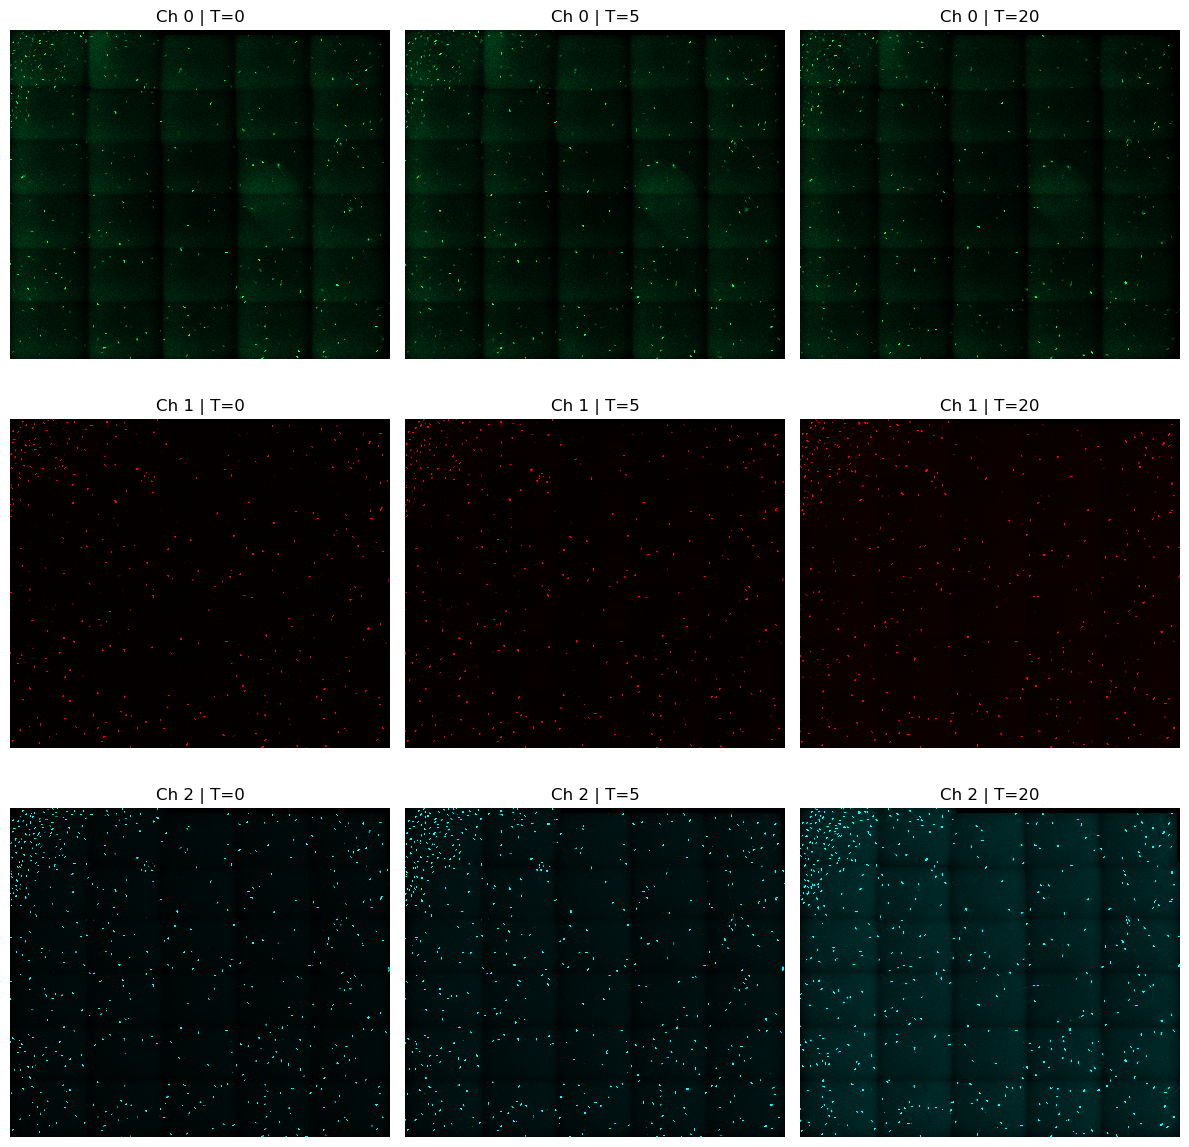

In [4]:
# Parameters
timepoints_to_show = [0, 5, 20]  # which T indices to plot
C, T, Y, X, _ = img.shape

fig, axes = plt.subplots(C, len(timepoints_to_show),
                         figsize=(4*len(timepoints_to_show), 4*C))

for c in range(C):
    for j, t in enumerate(timepoints_to_show):
        ax = axes[c, j] if C > 1 else axes[j]
        ax.imshow(img[c, t], interpolation='nearest')
        ax.set_title(f"Ch {c} | T={t}")
        ax.axis("off")

plt.tight_layout()
plt.show()

In [7]:
def _probe_supported_props(labels, intensity_image=None):
    """Return list of regionprops_table properties supported by current skimage."""
    # Comprehensive candidate list of scalar/table-friendly props
    candidates = [
        "label", "area", "bbox", "bbox_area", "centroid", "eccentricity",
        "equivalent_diameter", "euler_number", "extent", "feret_diameter_max",
        "filled_area", "inertia_tensor_eigvals", "local_centroid",
        "major_axis_length", "minor_axis_length", "orientation",
        "perimeter", "perimeter_crofton", "solidity"
    ]
    supported = []
    for prop in candidates:
        try:
            regionprops_table(labels, intensity_image=intensity_image, properties=[prop])
            supported.append(prop)
        except Exception:
            # not supported in this skimage build
            pass
    return supported

def segment_single_channel_allprops(
    img,
    info,
    stardist_model,
    channel,                     # index or name
    prob_thresh=0.4,
    nms_thresh=0.2,
    summarize_channels="all"     # "all" or list of indices/names
):
    """
    Segment a single channel from (C, T, Y, X, 3), return labels and a table with:
      - ALL supported scalar region properties (auto-detected)
      - Intensity stats for every requested channel: mean/max/min/sum
      - Pixel + physical centroids
    """
    # ---- resolve channels ----
    ch_names = info.get("channels", [])
    def _to_idx(ch):
        return ch_names.index(ch) if isinstance(ch, str) else int(ch)

    seg_idx = _to_idx(channel)
    seg_name = ch_names[seg_idx] if seg_idx < len(ch_names) else f"Channel-{seg_idx}"

    if summarize_channels == "all":
        sum_idx = list(range(img.shape[0]))
    else:
        sum_idx = [_to_idx(c) for c in summarize_channels]
    if seg_idx not in sum_idx:
        sum_idx = [seg_idx] + sum_idx

    # ---- metadata (µm) ----
    sx = float(info["physical_pixel_size"]["X"])
    sy = float(info["physical_pixel_size"]["Y"])
    ox = float(info["origin"]["X"])
    oy = float(info["origin"]["Y"])
    unit_px = info["physical_pixel_size"].get("X_unit", "µm")
    unit_org = info["origin"].get("unit", "µm")
    if unit_px != unit_org:
        raise ValueError("Pixel-size and origin units differ; convert first.")

    # ---- shapes ----
    C, T, Y, X, _ = img.shape
    if not (0 <= seg_idx < C):
        raise IndexError(f"Channel index {seg_idx} out of range [0, {C-1}]")

    # ---- outputs ----
    segments = np.zeros((T, Y, X), dtype=np.int32)
    rows = []

    # ---- model ----
    model = StarDist2D.from_pretrained(stardist_model)

    # Probe supported properties once (using a dummy tiny label if needed later)
    # We'll probe on the fly after first successful frame to match your skimage build.
    supported_props = None

    with tqdm(total=T, desc=f"Segmenting [{seg_name}]", unit="frame") as pbar:
        for t in range(T):
            # segment on selected channel
            raw_seg = rgb2gray(img[seg_idx, t])
            try:
                labels, _ = model.predict_instances(
                    normalize(raw_seg),
                    prob_thresh=prob_thresh,
                    nms_thresh=nms_thresh
                )
            except Exception:
                pbar.update(1)
                continue

            segments[t] = labels.astype(np.int32, copy=False)

            # discover supported props (once)
            if supported_props is None:
                supported_props = _probe_supported_props(labels, intensity_image=raw_seg)

            # geometry + intensity from segmentation channel
            main_props = regionprops_table(
                labels,
                intensity_image=raw_seg,
                properties=supported_props + ["mean_intensity", "max_intensity", "min_intensity"]
            )
            df = pd.DataFrame(main_props)

            
            if df.empty:
                pbar.update(1)
                continue

            # physical centroids
            df["centroid_x_px"] = df["centroid-1"]
            df["centroid_y_px"] = df["centroid-0"]
            df["centroid_x_um"] = ox + df["centroid_x_px"] * sx
            df["centroid_y_um"] = oy + df["centroid_y_px"] * sy
            df["centroid_unit"] = unit_org

            # add segmentation-channel explicit names
            df.rename(columns={
                "mean_intensity": f"{seg_name}_mean",
                "max_intensity":  f"{seg_name}_max",
                "min_intensity":  f"{seg_name}_min",
            }, inplace=True)
            df[f"{seg_name}_sum"] = df[f"{seg_name}_mean"] * df["area"]

            # add intensity summaries for other channels
            for c in sum_idx:
                if c == seg_idx:
                    continue
                raw_c = rgb2gray(img[c, t])
                ch_label = ch_names[c] if c < len(ch_names) else f"Channel-{c}"
                add = regionprops_table(
                    labels,
                    intensity_image=raw_c,
                    properties=["label", "mean_intensity", "max_intensity", "min_intensity"]
                )
                add = pd.DataFrame(add).rename(columns={
                    "mean_intensity": f"{ch_label}_mean",
                    "max_intensity":  f"{ch_label}_max",
                    "min_intensity":  f"{ch_label}_min",
                })
                add[f"{ch_label}_sum"] = add[f"{ch_label}_mean"] * df["area"]
                df = df.merge(add, on="label", how="left")

            # annotate indices
            df["Time"] = t
            df["SegChannelIdx"] = seg_idx
            df["SegChannelName"] = seg_name

            rows.append(df)
            pbar.set_postfix({"T": t, "Cells": int(labels.max())})
            pbar.update(1)

    props = pd.concat(rows, ignore_index=True) if rows else pd.DataFrame()
    return segments, props

In [11]:
# Segment on channel index 2, but include intensity stats from all channels
n = 1 # timepoints
img_subset =  img[:, :n].copy()

segments, props = segment_single_channel_allprops(
    img_subset, info, "2D_versatile_fluo",
    channel=2,
    prob_thresh=0.2,
    nms_thresh=0.2,
    summarize_channels="all",  # or e.g., ["TaGFP", "mKate", "Cy5"]
)

print(segments.shape)     # (T, Y, X)
print(props.head())

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


Segmenting [Cy5]: 100%|██████████| 1/1 [00:25<00:00, 25.54s/frame, T=0, Cells=759]

(1, 2618, 3026)
   label   area  bbox-0  bbox-1  bbox-2  bbox-3  bbox_area   centroid-0  \
0      1  180.0     951     730     965     746      224.0   957.816667   
1      2  153.0     454    1142     468    1158      224.0   460.810458   
2      3  175.0     768     187     786     201      252.0   776.291429   
3      4  161.0    1977    2085    1989    2102      204.0  1981.993789   
4      5  187.0     489    1121     505    1137      256.0   496.732620   

    centroid-1  eccentricity  ...  TaGFP_max  TaGFP_min  TaGFP_sum  \
0   737.122222      0.489214  ...   0.740869   0.078858  80.975314   
1  1149.581699      0.734127  ...   0.740869   0.031991  33.508305   
2   193.051429      0.825644  ...   0.160522   0.067071  20.221748   
3  2092.900621      0.788379  ...   0.740869   0.081664  82.141901   
4  1128.171123      0.690691  ...   0.740869   0.029186  35.230816   

   mKate_mean  mKate_max  mKate_min  mKate_sum  Time  SegChannelIdx  \
0    0.161833   0.211949   0.005833  29.1

In [17]:
props.columns

Index(['label', 'area', 'bbox-0', 'bbox-1', 'bbox-2', 'bbox-3', 'bbox_area',
       'centroid-0', 'centroid-1', 'eccentricity', 'equivalent_diameter',
       'euler_number', 'extent', 'feret_diameter_max', 'filled_area',
       'inertia_tensor_eigvals-0', 'inertia_tensor_eigvals-1',
       'local_centroid-0', 'local_centroid-1', 'major_axis_length',
       'minor_axis_length', 'orientation', 'perimeter', 'perimeter_crofton',
       'solidity', 'Cy5_mean', 'Cy5_max', 'Cy5_min', 'centroid_x_px',
       'centroid_y_px', 'centroid_x_um', 'centroid_y_um', 'centroid_unit',
       'Cy5_sum', 'TaGFP_mean', 'TaGFP_max', 'TaGFP_min', 'TaGFP_sum',
       'mKate_mean', 'mKate_max', 'mKate_min', 'mKate_sum', 'Time',
       'SegChannelIdx', 'SegChannelName'],
      dtype='object')

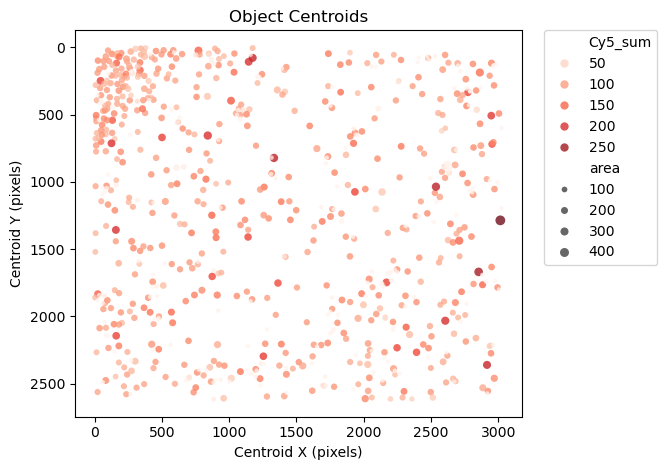

In [24]:
sns.scatterplot(
    data=props,
    x='centroid_x_px',
    y='centroid_y_px',
    hue='Cy5_sum',
    size='area',
    sizes=(10, 50),
    alpha=0.75,
    edgecolor="none",
    palette='Reds',
)

plt.gca().invert_yaxis()  # match image coordinate system
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel("Centroid X (pixels)")
plt.ylabel("Centroid Y (pixels)")
plt.title("Object Centroids")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()

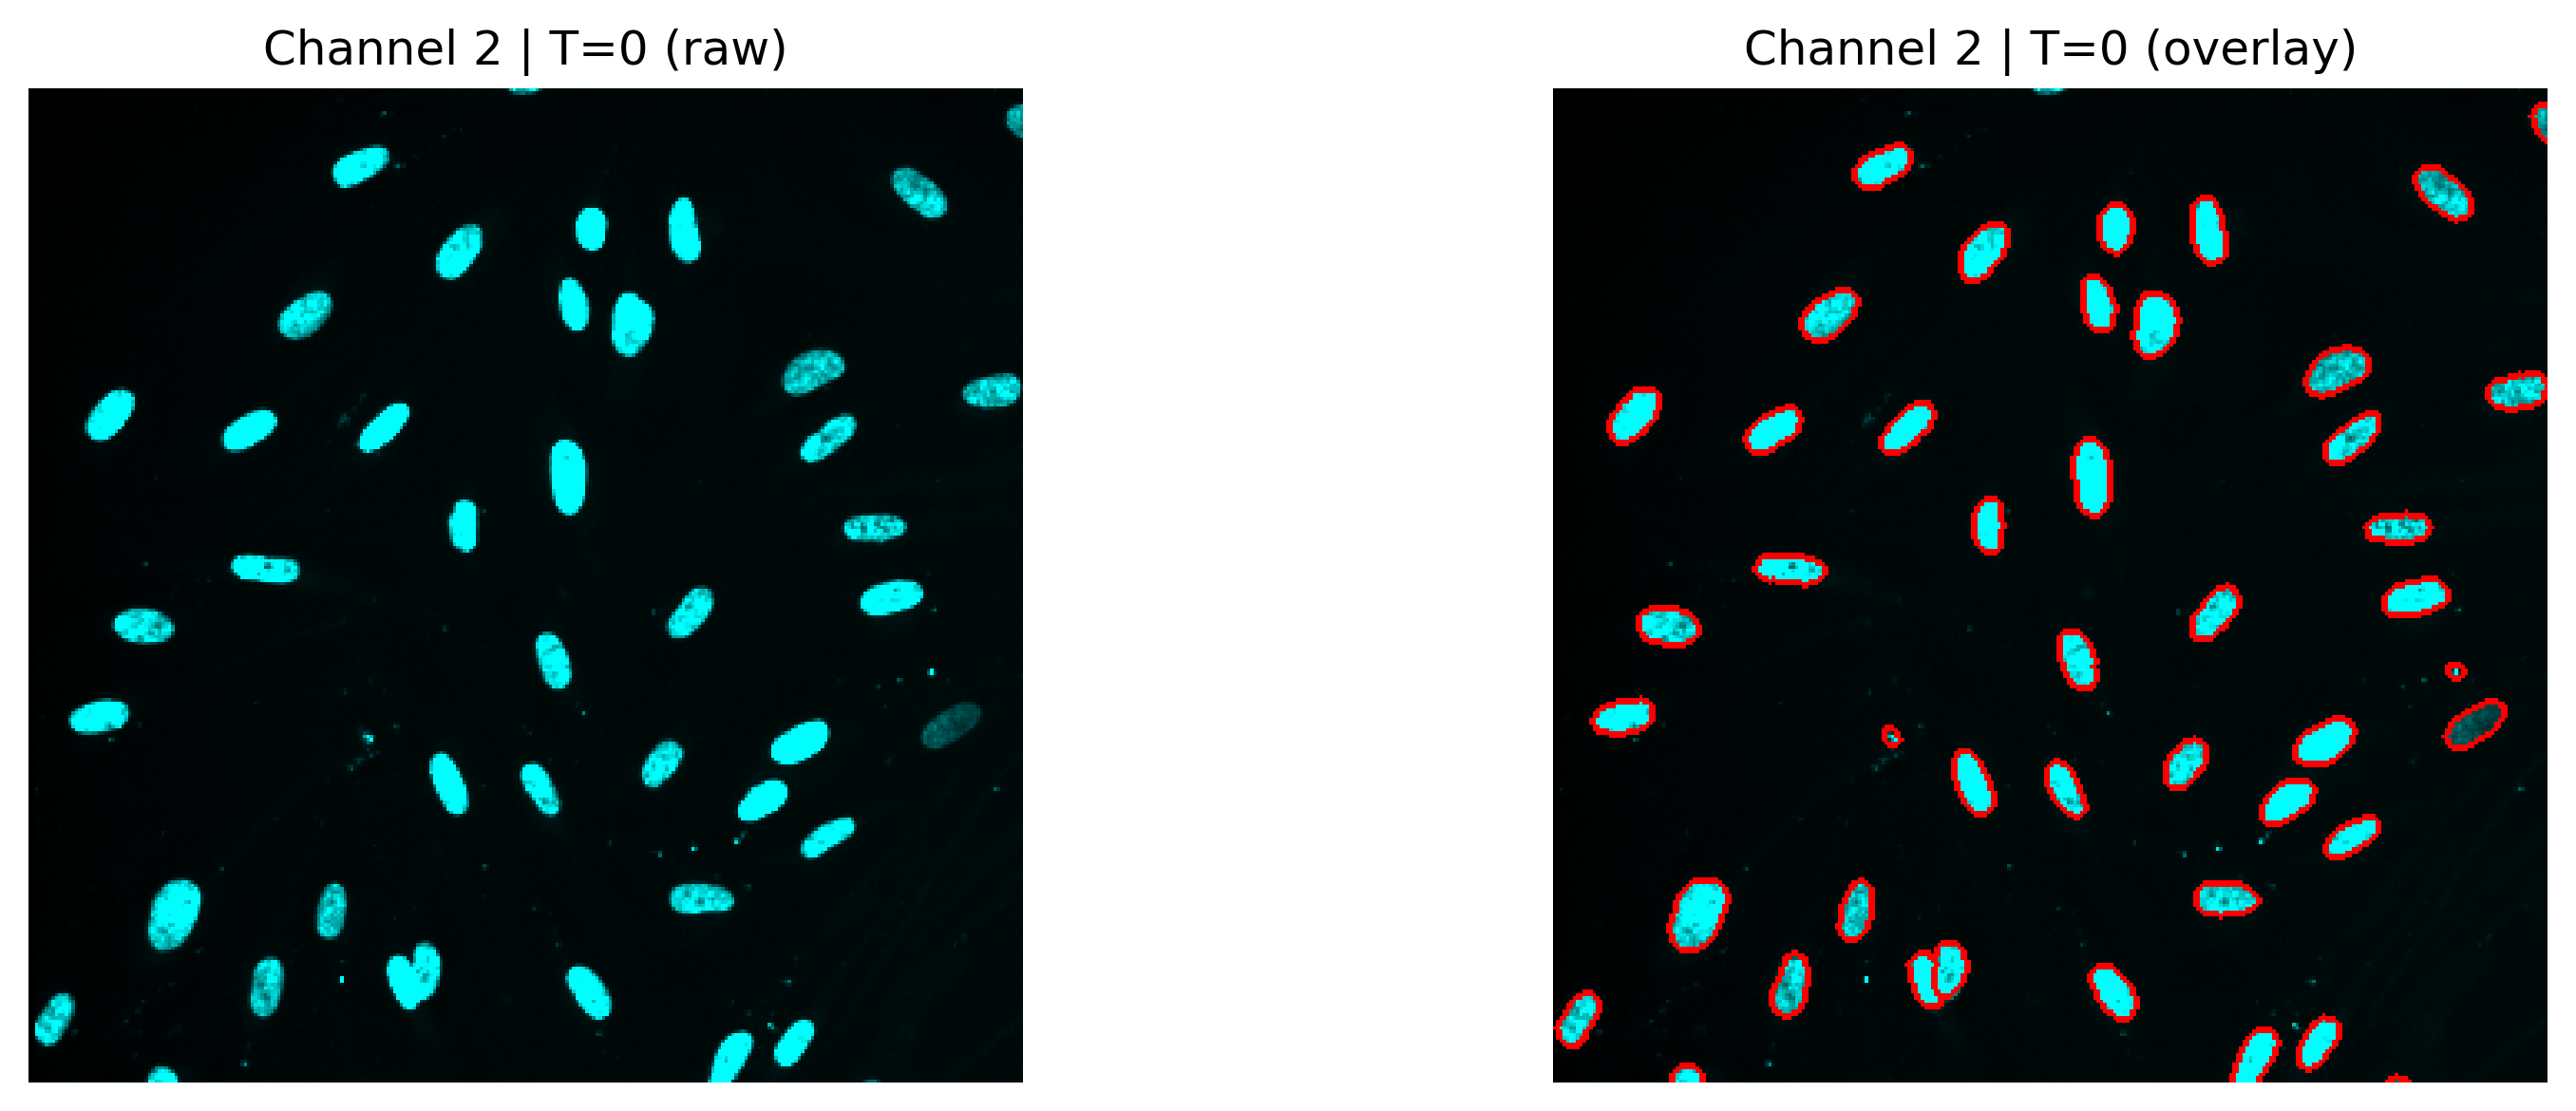

In [37]:
def plot_segment_overlays(img_CT_YX3, segments_TYX, props_df, channel_idx,
                          mode="contour", draw_bboxes=True, draw_labels=True,
                          edgecolor=(1,0,0), lw=1.5, dpi=300):
    """
    Plot overlays for a single-channel segmentation.
    - Left: raw frame
    - Right: red overlay (contour or fill) + optional red bounding boxes and IDs.

    img_CT_YX3 : (C, T, Y, X, 3)
    segments_TYX : (T, Y, X)
    props_df : DataFrame with at least ['Time','label'] and, if available,
               'bbox-0','bbox-1','bbox-2','bbox-3'
    channel_idx : int
    mode : "contour" or "fill"
    """
    T = segments_TYX.shape[0]
    frames = img_CT_YX3[channel_idx, :T]  # (T, Y, X, 3)

    ncols = 2  # raw + overlay
    fig, axes = plt.subplots(T, ncols, figsize=(6*ncols, 4*T), dpi=dpi)
    if T == 1:
        axes = np.array([axes])

    have_bbox_cols = props_df is not None and all(
        col in props_df.columns for col in ['bbox-0','bbox-1','bbox-2','bbox-3']
    )

    for t in range(T):
        raw = frames[t]
        lab = segments_TYX[t]

        # Left: raw
        ax0 = axes[t, 0]
        ax0.imshow(raw, interpolation="nearest")
        ax0.set_title(f"Channel {channel_idx} | T={t} (raw)")
        ax0.axis("off")

        # Right: overlay
        ax1 = axes[t, 1]
        if mode == "contour":
            ov = mark_boundaries(raw, lab, mode="thick", color=edgecolor)  # red contours
            ax1.imshow(ov, interpolation="nearest")
        else:  # "fill"
            base = rgb2gray(raw)
            colored = label2rgb(lab, image=base, bg_label=0, alpha=0.3,
                                colors=[edgecolor])  # red fill
            ax1.imshow(raw, interpolation="nearest")
            ax1.imshow(colored, interpolation="nearest", alpha=0.6)

        # Bounding boxes (red)
        if draw_bboxes:
            if have_bbox_cols:
                sub = props_df[props_df["Time"] == t]
                for _, r in sub.iterrows():
                    rmin, cmin, rmax, cmax = float(r['bbox-0']), float(r['bbox-1']), float(r['bbox-2']), float(r['bbox-3'])
                    w, h = (cmax - cmin), (rmax - rmin)
                    rect = Rectangle((cmin, rmin), w, h, linewidth=lw,
                                     edgecolor=edgecolor, facecolor='none')
                    ax1.add_patch(rect)
                    if draw_labels and 'label' in r:
                        ax1.text(cmin + w/2, rmin + h/2, int(r['label']),
                                 color='white', fontsize=8, ha='center', va='center')
            else:
                # fallback: compute from label image
                for rp in regionprops(lab):
                    rmin, cmin, rmax, cmax = rp.bbox
                    w, h = (cmax - cmin), (rmax - rmin)
                    rect = Rectangle((cmin, rmin), w, h, linewidth=lw,
                                     edgecolor=edgecolor, facecolor='none')
                    ax1.add_patch(rect)
                    if draw_labels:
                        ax1.text(cmin + w/2, rmin + h/2, int(rp.label),
                                 color='white', fontsize=8, ha='center', va='center')

        ax1.set_title(f"Channel {channel_idx} | T={t} (overlay)")
        ax1.axis("off")

    plt.tight_layout()
    plt.show()


# Define crop size
h_crop, w_crop = 300, 300

# Crop upper-left portion
img_crop = img_subset[:, :, :h_crop, :w_crop, :].copy()
segments_crop = segments[:, :h_crop, :w_crop].copy()

# Plot using your existing function
plot_segment_overlays(
    img_crop, segments_crop, props,
    channel_idx=2, mode="contour",
    draw_bboxes=False, draw_labels=False
)

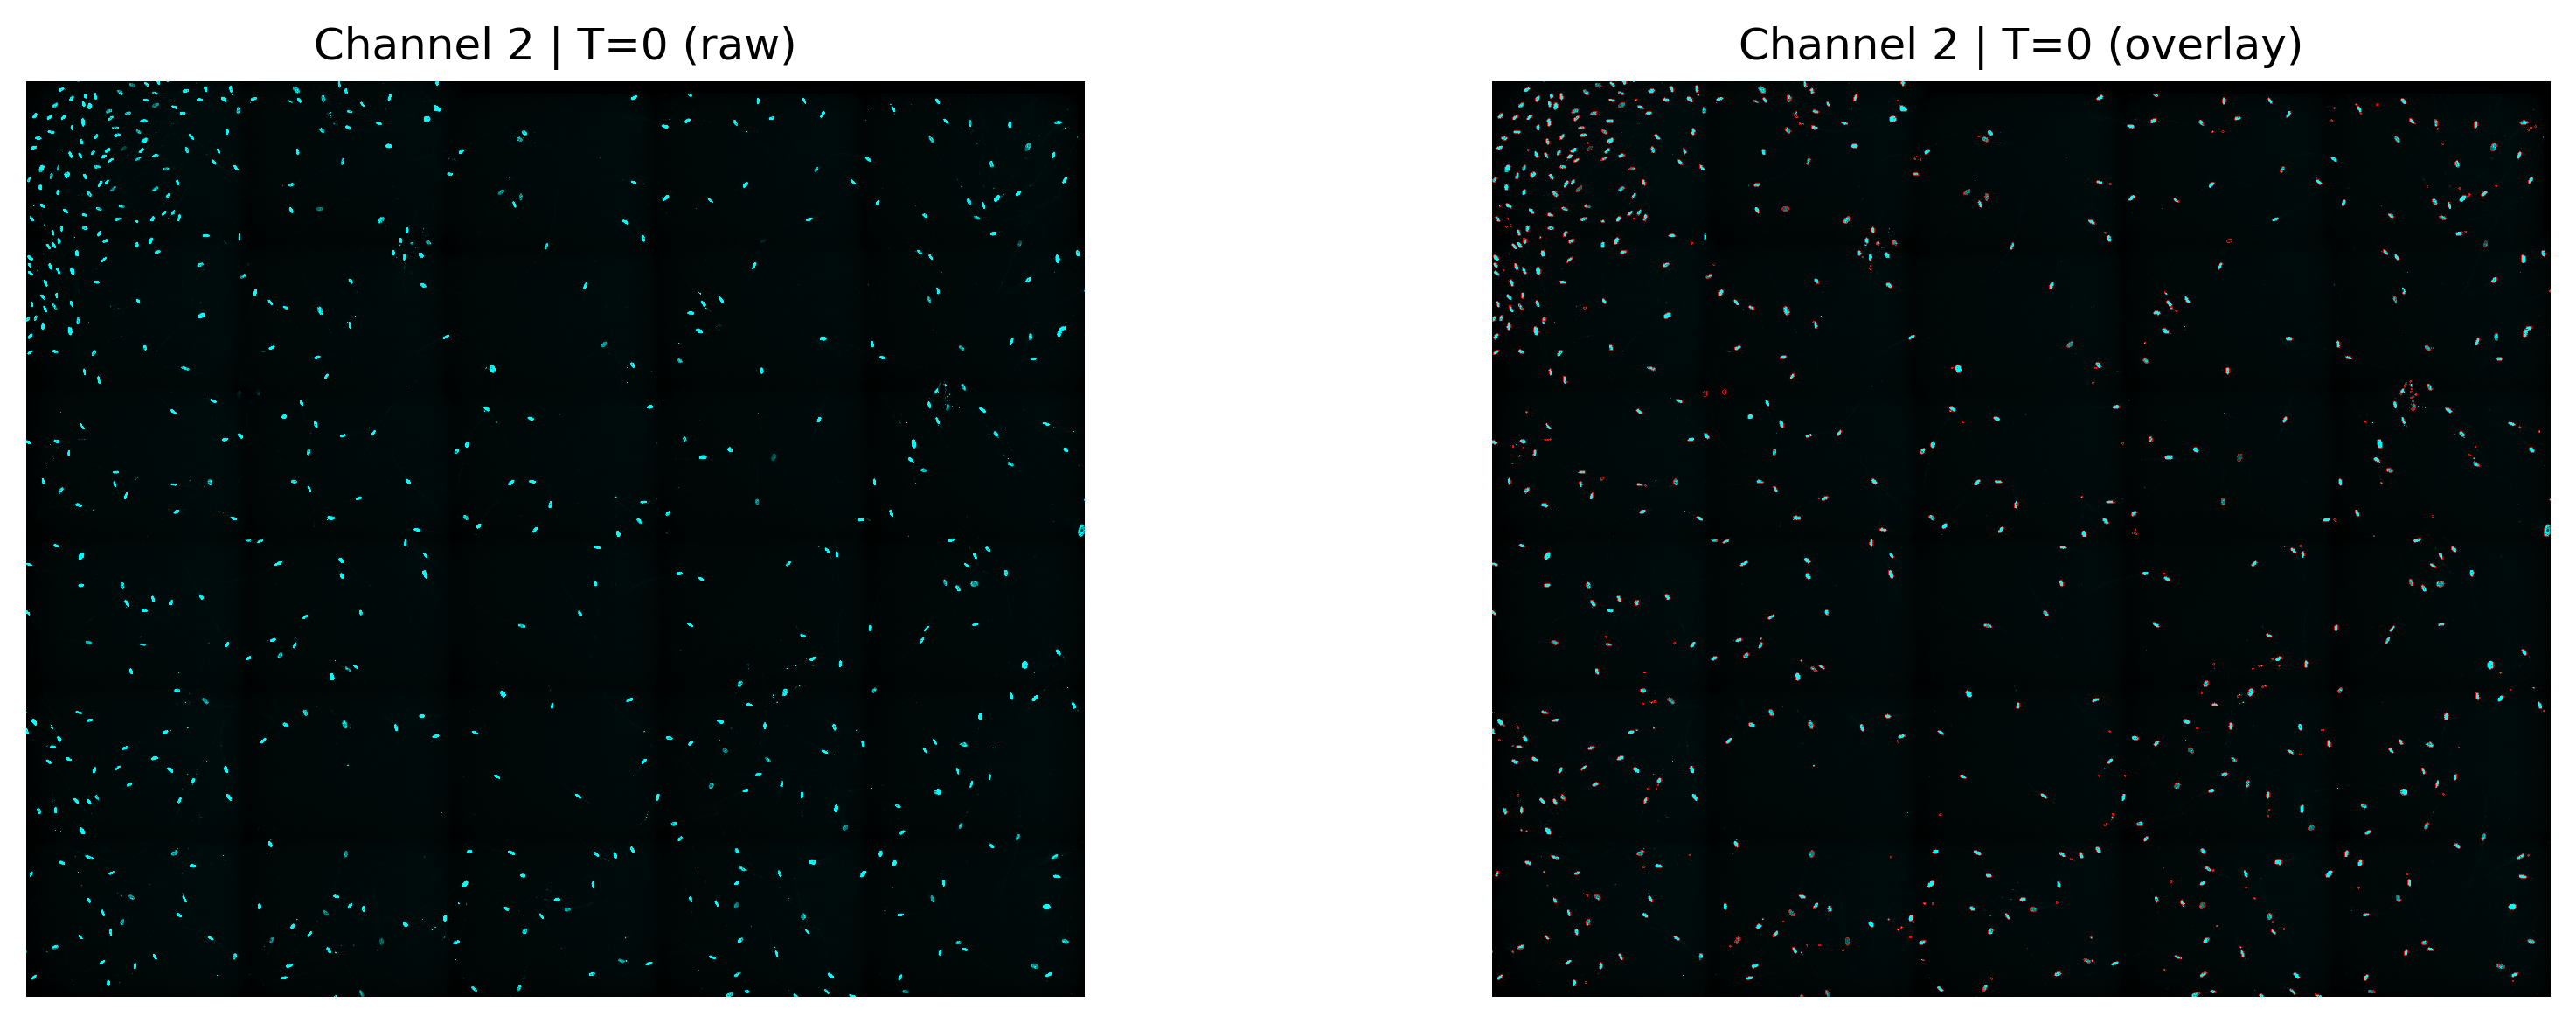

In [38]:
# Plot using your existing function
plot_segment_overlays(
    img_subset, segments, props,
    channel_idx=2, mode="contour",
    draw_bboxes=False, draw_labels=False
)

In [ ]:
break